
# CT421 Project 1  Evolutionary Search - GAs

**Aoife Mulligan 20307646 | Leo Chui 20343266**  



# Part B



## Representation

- Individuals are lists of binary strings
- Each string represents a bin, and all strings are of length $n$, the number of items
- 0 means that the item is not in current bin, and 1 means the item is in current bin
- length of list would be Number of bins
- also have an array which stores weights
  - e.g. for bin: \[10*1*01\], we can get the italicised 1's weight by getting the weight at the 2nd index in the weights array
  
### Recommended Testing bits

- compare repair performance with non-repair counterpart

### Miscellaneous bits

- Less heuristics could be a way to look at it

### Aoife's Notes

Mutation swapping seems like the only way to do mutation - as in, the nature of the problem means we can't mutate without swapping.
E.G. if n = 4 and two of our bins are: \[1100\] and \[0011\], we want to mutate only one chromosome. The first chromosome gets selected, so we flip the bit. Then we would have \[0100\] and \[0011\], but now the first item is not in a bin. We either must create an extra bin to place the first item (which seems crazy but I guess we could try), or we flip the corresponding bit in bin 2, so that the item is now in the other bin.

The only difference between this basic example and our implementation is that our implementation will have many bins, and so when we want to swap a bit, we should randomly select the bin for it to be swapped to.




#### Read Problem File


In [47]:
# read problem file to get items and weights

# open binpacking.txt
with open("Binpacking.txt", "r") as file:
    lines = file.readlines()

# removes till 'BPP      1'
for _ in range(17):
    lines.pop(0)

# from here, text file repeats in pattern
# BPP      i
# number of different weights
# capacity of bin
# weight          number of items (repeats number of different weights times)

CAPACITIES = []
ITEM_WEIGHTS = []

# loop through 5 BPP scenarios
for i in range(5):
    # remove seperator BPP i
    lines.pop(0)

    # saves number of different weights
    num_weights = int(lines.pop(0))
    # saves capacity of bin
    CAPACITIES.append(int(lines.pop(0)))
    # make new map for BPP scenario i
    ITEM_WEIGHTS.append([]) # append empty list
    
    # loop for weights number of times
    for j in range(num_weights):
        # split line into weight and number of items with weight
        line = lines.pop(0).split()

        # for each item of weight W, append W to weights[i] n times
        # n being the number of items with weight W, at line[1]
        for k in range(int(line[1])):
            ITEM_WEIGHTS[i].append(int(line[0]))
            print("Appending item with weight", line[0], "to BPP", i+1)
# close file
file.close()


Appending item with weight 200 to BPP 1
Appending item with weight 200 to BPP 1
Appending item with weight 200 to BPP 1
Appending item with weight 199 to BPP 1
Appending item with weight 198 to BPP 1
Appending item with weight 198 to BPP 1
Appending item with weight 197 to BPP 1
Appending item with weight 197 to BPP 1
Appending item with weight 194 to BPP 1
Appending item with weight 194 to BPP 1
Appending item with weight 193 to BPP 1
Appending item with weight 192 to BPP 1
Appending item with weight 191 to BPP 1
Appending item with weight 191 to BPP 1
Appending item with weight 191 to BPP 1
Appending item with weight 190 to BPP 1
Appending item with weight 190 to BPP 1
Appending item with weight 189 to BPP 1
Appending item with weight 188 to BPP 1
Appending item with weight 188 to BPP 1
Appending item with weight 187 to BPP 1
Appending item with weight 187 to BPP 1
Appending item with weight 186 to BPP 1
Appending item with weight 185 to BPP 1
Appending item with weight 185 to BPP 1


### Imports and Parameters

In [48]:
import matplotlib.pyplot as plt
import random

CROSSOVER_RATE = 0.9
POPULATION_SIZE = 100
NUM_GENERATIONS = 1000
ELITE_FACTOR = 0.1



### Helper functions


In [49]:
# helper functions

# calculate bin weights

def bin_sum_weight(bin, item_weights):
    # debug print to keep track of where we are
    # print("Calculating bin weight")
    sum_weight = 0
    for i in range(len(bin)):
        if int(bin[i]) == 1:
            sum_weight += item_weights[i]
    return sum_weight

# check clashes between bins
def check_clashes(bins):
    # XOR all bins should be a string of all 1s
    # return true if no clash
    for i in range(len(bins[0])):
        count_ones = sum([int(bins[j][i]) for j in range(len(bins))])
        if count_ones > 1:
            return False
    print("No clash")
    return True


### Fitness Function


In [50]:
# bin-packing fitness function
# calculates fitness by determining error for each bin
# actual bin weight - capacity
# perfect bin = 0

def capacity_error_fitness(bin, item_weights, capacity=1000):
    sum_weight = bin_sum_weight(bin, item_weights)
    error = (sum_weight - capacity) ** 2
    if sum_weight > capacity:
        error += 1000
    if check_clashes(bin) == False:
        error += 1000
    return error

In [51]:
# Tournament selection function

# selects k individuals from the population at random
# returns the index of the best individual

def tournament_selection(population, scores, k=3):
    # Select k individuals from population at random
    selection_i = random.randrange(len(population))
    
    for i in [random.randrange(len(population)) for _ in range(k-1)]:
        # Check if better (e.g. perform a tournament)
        if scores[i] < scores[selection_i]:
            selection_i = i
    # Return the index of the best
    return population[selection_i]

In [52]:
# mutation function
# each item has a 1/n chance of being mutated
# if mutated, item is swapped with another item

def mutate(bins):
    mutation_rate = 5/float(len(bins[0])) # 5%
    new_bins = bins.copy()
    for bin in bins:
        if random.random() < mutation_rate:
            # flip a bit in the string
            i = random.randint(0, len(bin)-1)
            # print("Bin before mutation:", bin)
            bin = bin[:i] + str(int(bin[i]) ^ 1) + bin[i+1:]
            # print("Bin after mutation:", bin)
        new_bins.append(bin)
    return new_bins
        

'''
    for i in range(len(bin1)):
        if random.random() < mutation_rate:
            # swap item in the bin with a corresponding item from another bin
            # flip the current bit in the string
            bin2 = random.choice(bins)
            # first check bin1 != bin2
            # second check that bin2[i] does not equal bin1[i]
            if bin1 != bin2 and bin1[i] != bin2[i]:
                # swap the item with a corresponding item from another bin
                print(i)
                print("Bin 1 before change:", bin1)
                print("Bin 2 before change:", bin2)
                bin1 = bin1[:i] + str(int(bin1[i]) ^ 1) + bin1[i+1:]
                bin2 = bin2[:i] + str(int(bin2[i]) ^ 1) + bin2[i+1:]
                print("Bin 1 after change:", bin1)
                print("Bin 2 after change:", bin2)
    return bins
'''

'\n    for i in range(len(bin1)):\n        if random.random() < mutation_rate:\n            # swap item in the bin with a corresponding item from another bin\n            # flip the current bit in the string\n            bin2 = random.choice(bins)\n            # first check bin1 != bin2\n            # second check that bin2[i] does not equal bin1[i]\n            if bin1 != bin2 and bin1[i] != bin2[i]:\n                # swap the item with a corresponding item from another bin\n                print(i)\n                print("Bin 1 before change:", bin1)\n                print("Bin 2 before change:", bin2)\n                bin1 = bin1[:i] + str(int(bin1[i]) ^ 1) + bin1[i+1:]\n                bin2 = bin2[:i] + str(int(bin2[i]) ^ 1) + bin2[i+1:]\n                print("Bin 1 after change:", bin1)\n                print("Bin 2 after change:", bin2)\n    return bins\n'

In [53]:
# TODO: crossover function

def crossover(parent1, parent2):
    if random.random() < CROSSOVER_RATE:
        # crossover point is a random point in the string
        crossover_point = random.randint(0, len(parent1)-1)

        # create two children
        child1 = parent1[:crossover_point] + parent2[crossover_point:]
        child2 = parent2[:crossover_point] + parent1[crossover_point:]
    else:
        child1, child2 = parent1, parent2
    return child1, child2


In [54]:
# elitism function

def elite_select(population, scores, elite_factor=ELITE_FACTOR):
    elite_size = int(len(population) * elite_factor)
    # Sort the population based on scores in ascending order
    sorted_population = [x for _, x in sorted(zip(scores, population))]

    # Select the elite individuals
    elite = sorted_population[:elite_size]

    # Return the elite individuals
    return elite


In [55]:
# BPP population generation function

def generate_population(item_weights, population_size=POPULATION_SIZE):
    population = []
    # while population is not full
    while len(population) < population_size:
        individual = []

        # make copy of item_weights at bpp_scenario
        item_list = item_weights.copy()

        # make a zero string as initial bin
        bin = ''.join('0' for _ in range(len(item_list)))

        # for each item in item_weights
        for i in range(len(item_list)):
            # check if weight would violate capacity
            # if weight does not violate capacity
            # add 1 to individual, representing the item
            if bin_sum_weight(bin, item_list) + item_list[i] <= CAPACITIES[0]:
                bin = bin[:i] + '1' + bin[i+1:]
            # if weight violates capacity, append bin to individual
            else:
                individual.append(bin)
                bin = ''.join('0' for _ in range(len(item_list)))
        individual.append(bin)

        population.append(individual)
        # print("Individual appended to population")
        # print("Population is now", population)
        # print("-------------------")
        """
        # make sure no strings in individual contains the same item
        # and append to population if no clash
        if check_clashes(individual):
                    population.append(individual)
        """
    return population


### Algorithm


In [56]:

# change algorithm so that crossover is only performed if the function is passed in

# Generic GA algorithm that is passed different functions

def algorithm(item_weights, bpp_scenario, pop_size=POPULATION_SIZE, elite_factor=ELITE_FACTOR,
              fitness=capacity_error_fitness, cross_rate=CROSSOVER_RATE, crossover=None):
    # define average fitness list to plot
    avg_fitness = []

    # initial random population
    population = generate_population(item_weights[bpp_scenario])

    # debug - print size of population
    print("Population size: %d" % len(population))

    # debug - print length of first bin of first solution
    print("Bin length: %d" % len(population[0][0]))
    print("Individual bins: %d" % len(population[0]))
    # debug - print first solution
    # print("First solution: %s" % population[0])

    individual_fitness = 0  # init individual fitness
    for i in range(len(population[0])):  # for every bin
        # add bin fitness to individual fitness
        individual_fitness += fitness(population[0]
                                      [i], item_weights[bpp_scenario])
    # Store temp best solution
    best_solution, best_fitness = population[0], individual_fitness

    # Loop generations
    for gen in range(NUM_GENERATIONS):

        # Evaluate all individuals in population
        scores = []
        for individual in population:
            # individual_fitness is the sum of the fitness of each bin of that individual
            individual_fitness = 0

            for bin in individual:
                individual_fitness += fitness(bin, item_weights[bpp_scenario])
            # store individual fitness in scores
            scores.append(individual_fitness)

        # calculate average fitness of generation
        avg_fitness.append(sum(scores) / pop_size)

        # print best score every 100 generations
        if gen % 99 == 0:
            print("Generation %d, best score = %.3f, average fitness = %.3f" %
                  (gen + 1, min(scores), avg_fitness[gen]))
        
        # Check for new best solution
        for i in range(pop_size):
            # print("Scores: ", scores[i])
            if scores[i] < best_fitness:
                best_solution, best_fitness = population[i], scores[i]
                print("Generation %d, new best f(%s) = %.3f" %
                      (gen, population[i], scores[i]))

        # Select parents to mutate or crossover or both
        parents = [tournament_selection(population, scores)
                   for _ in range(pop_size)]

        # Create next generation
        children = parents.copy()
        # elitism
        children.extend(elite_select(population, scores, elite_factor))

        # If the crossover function is passed in, perform crossover
        if crossover is not None:
            for i in range(0, pop_size, 2):
                    # perform crossover
                    children.extend(crossover(parents[i], parents[i+1]))
        for i in range(0, pop_size):
            children[i] = mutate(children[i])

        # Replace population
        # print("Length of children is ", len(children))
        population = children

    # plot average fitness over generations
    plt.plot(avg_fitness)
    plt.xlabel('Generation')
    plt.ylabel('Average Fitness')
    plt.show()

    return [best_solution, best_fitness]

BPP - 1
Running algorithm...
Population size: 100
Bin length: 100
Individual bins: 16
Generation 1, best score = 175826.000, average fitness = 175826.000


Generation 100, best score = 175826.000, average fitness = 886007.810
Generation 199, best score = 175826.000, average fitness = 825186.370
Generation 298, best score = 175826.000, average fitness = 964868.070
Generation 397, best score = 175826.000, average fitness = 900468.760
Generation 496, best score = 175826.000, average fitness = 981464.150
Generation 595, best score = 175826.000, average fitness = 787604.830
Generation 694, best score = 175826.000, average fitness = 915500.840
Generation 793, best score = 175826.000, average fitness = 942799.790
Generation 892, best score = 175826.000, average fitness = 1117453.060
Generation 991, best score = 175826.000, average fitness = 1052714.950


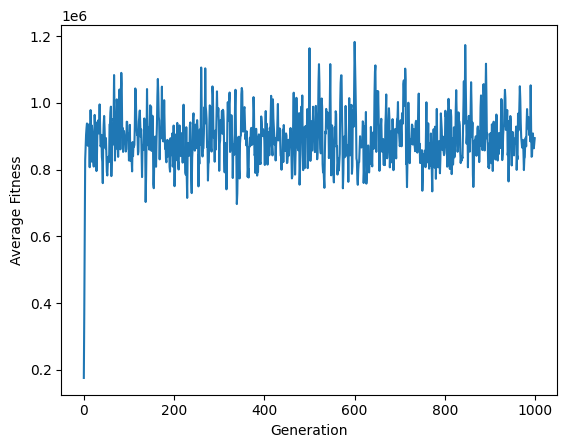

Best solution: %s ['1111100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', '0000001111100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', '0000000000001111100000000000000000000000000000000000000000000000000000000000000000000000000000000000', '0000000000000000001111100000000000000000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000001111100000000000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000001111100000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000001111100000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000001111100000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000001111100000000000000000000000000000000000000000000000', '00000000000000000000000000000000000000000000

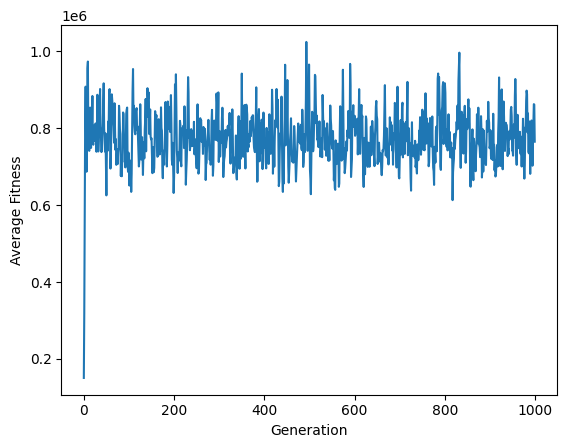

Best solution: %s ['1111100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', '0000001111100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', '0000000000001111100000000000000000000000000000000000000000000000000000000000000000000000000000000000', '0000000000000000001111100000000000000000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000001111100000000000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000001111100000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000001111100000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000001111100000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000001111100000000000000000000000000000000000000000000000', '00000000000000000000000000000000000000000000

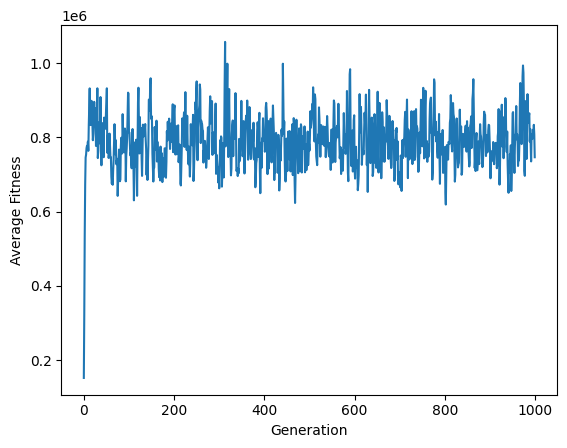

Best solution: %s ['1111100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', '0000001111100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', '0000000000001111100000000000000000000000000000000000000000000000000000000000000000000000000000000000', '0000000000000000001111100000000000000000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000001111100000000000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000001111100000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000001111100000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000001111100000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000001111100000000000000000000000000000000000000000000000', '00000000000000000000000000000000000000000000

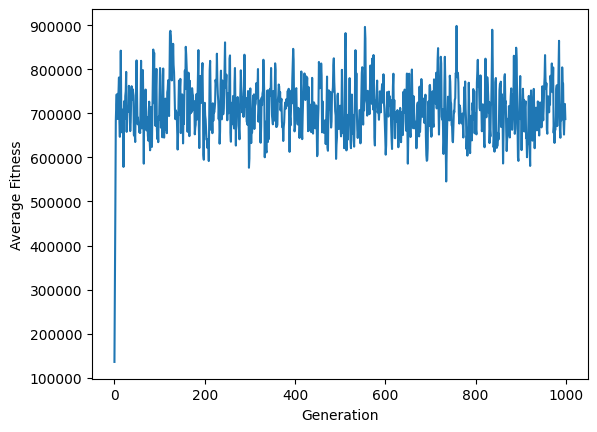

Best solution: %s ['1111100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', '0000001111100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', '0000000000001111100000000000000000000000000000000000000000000000000000000000000000000000000000000000', '0000000000000000001111100000000000000000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000001111100000000000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000001111100000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000001111100000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000001111100000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000001111100000000000000000000000000000000000000000000000', '00000000000000000000000000000000000000000000

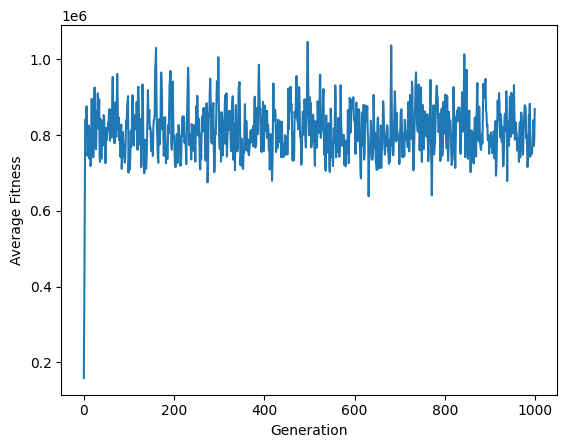

Best solution: %s ['1111100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', '0000001111100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000', '0000000000001111100000000000000000000000000000000000000000000000000000000000000000000000000000000000', '0000000000000000001111100000000000000000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000001111100000000000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000001111100000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000001111100000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000001111100000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000001111100000000000000000000000000000000000000000000000', '00000000000000000000000000000000000000000000

In [57]:
if __name__ == '__main__':    
    """

    print("BPP - 1")
    print("Running algorithm...")
    solution, score = algorithm(
        ITEM_WEIGHTS, bpp_scenario=0, crossover=crossover)
    print("Best solution: %s", solution)
    print("Best score: %.3f", score)

    print("\n \n \n")

    print("BPP - 2")
    print("Running algorithm...")
    solution, score = algorithm(
        ITEM_WEIGHTS, bpp_scenario=1, crossover=crossover)
    print("Best solution: %s", solution)
    print("Best score: %.3f", score)

    print("\n \n \n")

    print("BPP - 3")
    print("Running algorithm...")
    solution, score = algorithm(
        ITEM_WEIGHTS, bpp_scenario=2, crossover=crossover)
    print("Best solution: %s", solution)
    print("Best score: %.3f", score)
    
    print("\n \n \n")
    
    print("BPP - 4")
    print("Running algorithm...")
    solution, score = algorithm(
        ITEM_WEIGHTS, bpp_scenario=3, crossover=crossover)
    print("Best solution: %s", solution)
    print("Best score: %.3f", score)
    
    print("\n \n \n")
    
    print("BPP - 5")
    print("Running algorithm...")
    solution, score = algorithm(
        ITEM_WEIGHTS, bpp_scenario=4, crossover=crossover)
    print("Best solution: %s", solution)
    print("Best score: %.3f", score)

    print("\n \n \n")
"""
    print("BPP - 1")
    print("Running algorithm...")
    solution, score = algorithm(
        ITEM_WEIGHTS, bpp_scenario=0)
    print("Best solution: %s", solution)
    print("Best score: %.3f", score)

    print("\n \n \n")

    print("BPP - 2")
    print("Running algorithm...")
    solution, score = algorithm(
        ITEM_WEIGHTS, bpp_scenario=1)
    print("Best solution: %s", solution)
    print("Best score: %.3f", score)

    print("\n \n \n")

    print("BPP - 3")
    print("Running algorithm...")
    solution, score = algorithm(
        ITEM_WEIGHTS, bpp_scenario=2)
    print("Best solution: %s", solution)
    print("Best score: %.3f", score)
    
    print("\n \n \n")
    
    print("BPP - 4")
    print("Running algorithm...")
    solution, score = algorithm(
        ITEM_WEIGHTS, bpp_scenario=3)
    print("Best solution: %s", solution)
    print("Best score: %.3f", score)
    
    print("\n \n \n")
    
    print("BPP - 5")
    print("Running algorithm...")
    solution, score = algorithm(
        ITEM_WEIGHTS, bpp_scenario=4)
    print("Best solution: %s", solution)
    print("Best score: %.3f", score)

    print("\n \n \n")
    print("Completed operations")